In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import h5py
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import imageio.v2 as imageio
import random
import time


# Setup

In [2]:
# Size of the object
object_shape = (512, 512)

# Side length of the probe
n_probe = 128

# Probe shift for intensity measurement
shift = 64


## Realistic Synthetic Object and Probe

In [3]:
mat_data = scipy.io.loadmat('recon_zoneplate_Yi.mat')
obj = mat_data['obj']
orgn_probe = mat_data['probe']

pad_x = (object_shape[0] - obj.shape[0]) // 2
pad_y = (object_shape[1] - obj.shape[1]) // 2

# Pad the object to the desired shape
real_object = np.pad(obj, ((pad_x, pad_x), (pad_y, pad_y)), mode='edge')

ratio = orgn_probe.shape[0] // n_probe

real_probe = orgn_probe[::ratio,::ratio]

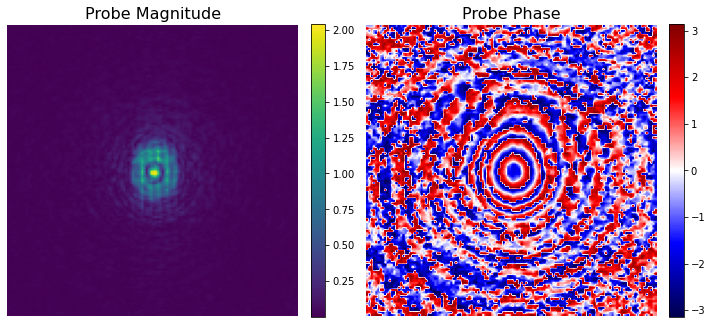

In [4]:
# Compute magnitude and phase
magnitude = np.abs(real_probe)
phase = np.angle(real_probe)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
im0 = ax.imshow(magnitude, cmap='viridis')
ax.set_title('Probe Magnitude', fontsize = 16)
ax.axis('off')
plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1]
im1 = ax.imshow(phase, cmap='seismic')
ax.set_title('Probe Phase', fontsize = 16)
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.savefig('probe_mag_phase.png', dpi=120, bbox_inches='tight')
plt.show()

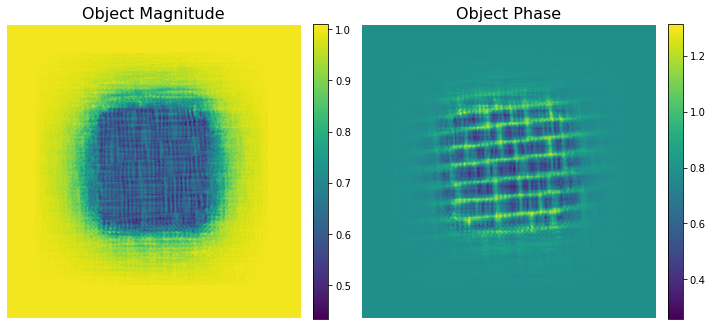

In [5]:
magnitude = np.abs(real_object)
phase = np.angle(real_object)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
im0 = ax.imshow(magnitude, cmap='viridis')
ax.set_title('Object Magnitude', fontsize = 16)
ax.axis('off')
plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1]
im1 = ax.imshow(phase, cmap='viridis')
ax.set_title('Object Phase', fontsize = 16)
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.savefig('realistic_object.png', dpi=120, bbox_inches='tight')
plt.show()

## Test Synthetic Object 

In [6]:
# Load the images
baboon_image = imageio.imread('baboon.tiff')
# Convert the Baboon image to grayscale 
if baboon_image.ndim == 3:
    baboon_image = np.mean(baboon_image, axis=2)
    
cameraman_image = imageio.imread('cameraman.tif')
if cameraman_image.ndim == 3:
    cameraman_image = np.mean(cameraman_image, axis=2)

# Normalize the Baboon image to [0, 1] for magnitude
baboon_magnitude = baboon_image / np.max(baboon_image)

# Normalize the Cameraman image to [0, pi/2] for phase
cameraman_phase = (cameraman_image / np.max(cameraman_image)) * (np.pi / 2)

synthetic_object = baboon_magnitude * np.exp(1j * cameraman_phase)


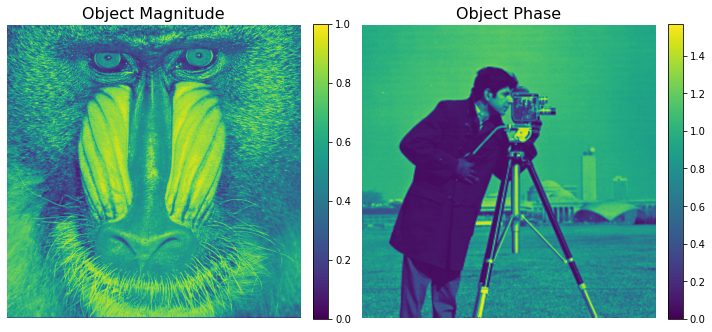

In [7]:
magnitude = np.abs(synthetic_object)
phase = np.angle(synthetic_object)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
im0 = ax.imshow(magnitude, cmap='viridis')
ax.set_title('Object Magnitude', fontsize = 16)
ax.axis('off')
plt.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1]
im1 = ax.imshow(phase, cmap='viridis')
ax.set_title('Object Phase', fontsize = 16)
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
#plt.savefig('synthetic_object.png', dpi=120, bbox_inches='tight')
plt.show()


## Data Generation

In [8]:
def generate_intensity_measurements(z, Q, positions, noise_level):
    measurements = []
    for position in positions:
        x, y = position
        object_patch = z[x:x+Q.shape[0], y:y+Q.shape[1]]
        exit_wave = Q * object_patch
        d_k = np.abs(fft2(exit_wave))**2
        
        if noise_level > 0:
            # Scale the intensity to control noise level
            scaled_d_k = d_k / noise_level
            
            # Add Poisson noise
            noisy_scaled_d_k = np.random.poisson(scaled_d_k)
            # Scale back the noisy data to the original range
            d_k_noisy = noisy_scaled_d_k * noise_level
        else:
            # No noise added, return the original data
            d_k_noisy = d_k
        
        measurements.append(d_k_noisy)
    return np.array(measurements)


In [9]:
# Choose Object
probe = real_probe
ground_truth = synthetic_object

# Noise added to the measurement
noise_level = 0.05

# Define scanning positions
def positions(level):
    return [(x, y) for x in range(0, object_shape[0]//2**level - n_probe//2**level + 1, shift//2**level)
                    for y in range(0, object_shape[1]//2**level - n_probe//2**level + 1, shift//2**level)]

# Generate the data
data = generate_intensity_measurements(ground_truth, probe, positions(0), noise_level)


## Misfits

In [10]:
def feasibility_distance_misfit(z, Q, data, pos_array):
    m = data.shape[1]
    n = int(np.sqrt(z.size))
    N = data.shape[0]

    f   = 0
    g   = 0
    dfz = np.zeros(2 * n * n, dtype=float)

    z = z.reshape(n, n)
    Q = Q.reshape(m, m)

    for k in range(N):
        x, y = pos_array[k]
        z_k  = z[x:x+m, y:y+m]
        ew_k = Q * z_k

        # Fourier and inverse Fourier operations
        fft_ew_k = fft2(ew_k)
        rew_k    = ifft2(np.sqrt(data[k]) * np.exp(1j * np.angle(fft_ew_k)))
        res_k    = ew_k - rew_k  

        # Calculating the residual and the gradient
        f += 0.5 * np.linalg.norm(res_k.flatten(), 2)**2

        dfz_temp = np.conj(Q) * res_k
        g       += np.linalg.norm(dfz_temp.flatten(), 2) / N / m
        dfz_k    = np.zeros((n, n), dtype=complex)
        dfz_k[x:x+m, y:y+m] = dfz_temp
        
        dfz += dfz_k.flatten().view(float)

    return f, dfz, g

# Algorithms

In [11]:
def downsample(vh):
    if len(vh.shape) == 1:
        nh = int(np.sqrt(vh.shape[0]))
        vh = vh.reshape(nh, nh)
    nh = vh.shape[0] 
    nw = vh.shape[1] 
    vH = 0.25 * (
        vh[0:nh:2, 0:nw:2] +
        vh[0:nh:2, 1:nw:2] +
        vh[1:nh:2, 0:nw:2] +
        vh[1:nh:2, 1:nw:2]
    )
    return vH

def upsample(vH):
    if len(vH.shape) == 1:
        nH = int(np.sqrt(vH.shape[0]))
        vH = vH.reshape(nH, nH)
    vh = np.repeat(np.repeat(vH, 2, axis=0), 2, axis=1)
    return vh

def args_init(data):
    return np.zeros_like(data, dtype=float)

def REW(Q, z_k, d_k, args_pre):
    exit_wave = Q * z_k
    exit_wave_ft = fft2(exit_wave)
    mask = np.abs(exit_wave_ft) == 0
    args = np.angle(exit_wave_ft)
    args[mask] = args_pre[mask]
    rew = ifft2(np.sqrt(d_k) * np.exp(1j * args))
    return rew, args

def W_u(Q_sq, Q_H_sq):
    A = Q_H_sq 
    B = downsample(Q_sq)
    return np.divide(A, B, where=(B != 0), out=np.ones_like(A))

def W(Q_sq):
    A = Q_sq 
    B = upsample(downsample(Q_sq))
    return np.divide(A, B, where=(B != 0), out=np.zeros_like(A))

def W_rew(Q):
    Q_sq = np.abs(Q)**2
    A = Q_sq*upsample(downsample(Q))
    B = upsample(downsample(Q_sq))*Q
    return np.divide(A, B, where=(np.abs(B) != 0), out=np.zeros_like(A))

## rPIE

In [12]:
def rPIE_rand(z_init, Q, data, pos_array, num_iter, alpha=0.01, metric = False, gt = ground_truth, tol = 0.001):
    z_recon = z_init.copy()
    Q_abs   = np.abs(Q)
    Q_maxsq = np.max(Q_abs)**2
    Q_sq    = Q_abs**2
    step    = np.conj(Q) / ((1 - alpha)*Q_sq + alpha*Q_maxsq) 
    
    m    = Q.shape[0]
    res  = []
    err  = []
    arr  = list(range(len(pos_array))) 
    args = args_init(data)     
    
    if metric:
            f, df, g = feasibility_distance_misfit(z_recon, Q, data, pos_array)
            res.append(f)
            err.append(np.linalg.norm(np.abs(z_recon) - np.abs(gt)))
            print(f'Iteration: {0}, f: {f}, g: {g}, error: {err[-1]}')   
     
    for j in range(num_iter):
        random.shuffle(arr)
        
        for k in arr:
            x, y = pos_array[k]
            z_k  = z_recon[x:x+m, y:y+m]
            rew_k, args[k] = REW(Q, z_k, data[k], args[k])
            z_recon[x:x+m, y:y+m] += step * (rew_k - Q * z_k)    
            
        if metric:
            f, df, g = feasibility_distance_misfit(z_recon, Q, data, pos_array)
            res.append(f)
            err.append(np.linalg.norm(np.abs(z_recon) - np.abs(gt)))
            print(f'Iteration: {j+1}, f: {f}, g: {g}, error: {err[-1]}')   
            if g < tol:
                j -= 1
                break
                
    return z_recon, np.array(res), np.array(err) 


## MAGPIE

In [13]:
def MAGPS(z_k, Q, rew, u):
    '''Recursively update z_k using probe Q and measurement rew_k.
    Base case: stop when downsampled Q has size 1x1.'''
    # Compute step for this level
    Q_sq = np.abs(Q) ** 2
    Q_sqmax = np.max(Q_sq)
    step = np.conj(Q) / (Q_sq + u)
    
    # Base case: if coarse region is 1x1, apply update and return
    if z_k.shape == (1, 1):
        return z_k + step * (rew - Q * z_k)
    
    # Compute coarse-level terms
    Q_H    = downsample(Q)
    Q_H_sq = np.abs(Q_H) ** 2
    z_H    = downsample(W(Q_sq) * z_k)
    rew_H  = downsample(W_rew(Q) * rew)
    u_H    = W_u(Q_sq, Q_H_sq) * downsample(u)  
    
    z_H_hat = MAGPS(z_H, Q_H, rew_H, u_H)

    # Propagate update up and apply fine-level correction
    z_k_tilde = z_k + upsample(z_H_hat - z_H)
    z_k_plus  = z_k_tilde + step * (rew - Q * z_k_tilde)
    return z_k_plus


def MAGPIE_recursion(z_init, Q, data, pos_array, num_iter, alpha=0.01, metric=False, gt=ground_truth, tol=1e-4):
    z       = z_init.copy()
    args    = args_init(data)
    res     = []
    err     = []
    h, w    = Q.shape
    Q_sq    = np.abs(Q) ** 2
    Q_sqmax = np.max(Q_sq)
    u       = alpha * (Q_sqmax - Q_sq)
    arr     = list(range(len(pos_array))) 
    
    if metric:
        f, _, g = feasibility_distance_misfit(z, Q, data, pos_array)
        res.append(f)
        err.append(np.linalg.norm(np.abs(z) - np.abs(gt)))
        print(f'Iteration: {0}, f: {f}, g: {g}, error: {err[-1]}')   
     
    for j in range(num_iter):
        random.shuffle(arr)
        
        for k in arr:
            x, y = pos_array[k]
            z_k  = z[x:x+h, y:y+w]
            rew, args[k] = REW(Q, z_k, data[k], args[k])

            z_k_plus = MAGPS(z_k, Q, rew, u)
            z[x:x+h, y:y+w] = z_k_plus
            
        if metric:
            f, _, g = feasibility_distance_misfit(z, Q, data, pos_array)
            res.append(f)
            err.append(np.linalg.norm(np.abs(z) - np.abs(gt)))
            print(f'Iteration: {j+1}, f: {f}, g: {g}, error: {err[-1]}')   
            if g < tol:
                j -= 1
                break
            
    return z, np.array(res), np.array(err)


In [14]:
def MAGPIE_loops(z_init, Q, data, pos_array, 
                num_iter, alpha=0.01, metric=False, 
                gt=ground_truth, tol=1e-4, max_level=7):
    
    h, w   = Q.shape
    # Number of levels is max_level+1 (0 through max_level)
    levels = max_level + 1

    # 1) Build downsampled Qs
    Qs    = [None] * levels
    Qs[0] = Q.copy()
    for level in range(1, levels):
        Qs[level] = downsample(Qs[level-1])

    # 2) Precompute Q_sq and regularizaiton terms us
    Q_sq     = [np.abs(q)**2 for q in Qs]
    Q0_sqmax = np.max(Q_sq[0])

    us    = [None] * levels
    us[0] = alpha * (Q0_sqmax - Q_sq[0])
    for level in range(1, levels):
        us[level] = W_u(Q_sq[level-1], Q_sq[level]) * downsample(us[level-1])

    # 3) Compute step sizes
    steps = [
        np.conj(Qs[level]) / (Q_sq[level] + us[level])
        for level in range(levels)
    ]

    # 4) Precompute downsampling weights for z and rew
    Wz   = [W(Q_sq[level]) for level in range(levels-1)]
    Wrew = [W_rew(Qs[level]) for level in range(levels-1)]

    # 5) Initialize variables
    z    = z_init.copy()
    args = args_init(data)
    arr  = list(range(len(pos_array)))

    res = []
    err = []

    if metric:
        f, _, g = feasibility_distance_misfit(z, Q, data, pos_array)
        res.append(f)
        err.append(np.linalg.norm(np.abs(z) - np.abs(gt)))
        print(f'Iteration: {0}, f: {f}, g: {g}, error: {err[-1]}')   
     
    for j in range(num_iter):
        random.shuffle(arr)

        # Loop over scanning positions
        for k in arr:
            x, y = pos_array[k]
            z_k  = z[x:x+h, y:y+w]

            # Down-pass: build lists of z_patches and rew_values
            z_patches = [z_k]
            rew_vals = [None] * levels

            # Level 0 rew
            rew_vals[0], args[k] = REW(Q, z_k, data[k], args[k])

            # Levels 1…max_level: downsample
            for level in range(1, levels):
                z_down   = downsample(Wz[level-1] * z_patches[level-1])
                rew_down = downsample(Wrew[level-1] * rew_vals[level-1])
                z_patches.append(z_down)
                rew_vals[level] = rew_down

            # Up-pass: correction from coarsest level back to 0
            z_new  = z_patches[-1].copy()
            z_new += steps[-1] * (rew_vals[-1] - Qs[-1] * z_new)

            for level in range(levels-2, -1, -1):
                # upsample correction
                delta  = upsample(z_new - z_patches[level+1])
                z_new  = z_patches[level].copy() + delta
                z_new += steps[level] * (rew_vals[level] - Qs[level] * z_new)

            # Write updated patch back into z
            z[x:x+h, y:y+w] = z_new
            
        if metric:
            f, _, g = feasibility_distance_misfit(z, Q, data, pos_array)
            res.append(f)
            err.append(np.linalg.norm(np.abs(z) - np.abs(gt)))
            print(f'Iteration: {j+1}, f: {f}, g: {g}, error: {err[-1]}')   
            if g < tol:
                j -= 1
                break

    return z, np.array(res), np.array(err)


## L-BFGS

In [15]:
def line_s(p, x, f, g, sfun, alpha=1.0, rho=0.8, c=1e-4, max_iter=20, eval_counters=None, eval_increment = 1):
    iter_count = 0
    while iter_count < max_iter:
        x_new = x + alpha * p
        f_new, g_new, g2 = sfun(x_new)
        if eval_counters is not None:
            eval_counters['func'] += eval_increment  
        if f_new <= f + c * alpha * np.dot(g, p):
            eval_counters['grad'] += eval_increment
            return x_new, f_new, g_new, g2, alpha
        alpha *= rho
        iter_count += 1    
    return x_new, f_new, g_new, g2, alpha

def lBFGS(x0, sfun, maxiter=100, m=5, gt=ground_truth, tol = 0.001):
    x = x0
    f, g, g2 = sfun(x)
    eval_counters = {'func': 1, 'grad': 1}
    eval_history = {'func': [1], 'grad': [1], 'f': [f], 'g2': [g2], 'error': [np.linalg.norm(np.abs(x.view(np.complex128).reshape(object_shape))-np.abs(gt))]}  
    
    n = len(x0)
    S = np.zeros((n, m))
    Y = np.zeros((n, m))
    rho_list = np.zeros(m)
    h0 = 1.0
    counter = 1
    
    for k in range(maxiter):
        if g2 < tol:
            if counter > 10:
                break
            else:
                counter += 1
            
        q = g
        alpha_list = np.zeros(m)
        
        for i in range(min(k, m)):
            j = (k - i - 1) % m
            rho_list[j] = 1.0 / np.dot(Y[:, j], S[:, j])
            alpha_list[j] = rho_list[j] * np.dot(S[:, j], q)
            q = q - alpha_list[j] * Y[:, j]
        
        r = h0 * q
        
        for i in range(min(k, m)):
            j = (k - min(k, m) + i) % m
            beta = rho_list[j] * np.dot(Y[:, j], r)
            r = r + S[:, j] * (alpha_list[j] - beta)
        
        p = -r
        
        x_new, f_new, g_new, g2, alpha = line_s(p, x, f, g, sfun, max_iter=100, eval_counters=eval_counters)
        
        s = x_new - x
        y = g_new - g
        
        if k < m:
            S[:, k] = s
            Y[:, k] = y
        else:
            S = np.roll(S, -1, axis=1)
            Y = np.roll(Y, -1, axis=1)
            S[:, -1] = s
            Y[:, -1] = y
        
        h0 = np.dot(s, y) / np.dot(y, y)
        
        x = x_new
        f = f_new
        g = g_new
        
        eval_history['func'].append(eval_counters['func'])
        eval_history['grad'].append(eval_counters['grad'])
        eval_history['f'].append(f)
        eval_history['g2'].append(g2)   
        eval_history['error'].append(np.linalg.norm(np.abs(x.view(np.complex128).reshape(object_shape))-np.abs(gt)))
        print(f"Iter {k+1}, f = {f}, g = {g2}, Func Evals = {eval_history['func'][-1]}, Error = {eval_history['error'][-1]}")

    return x, f, eval_history


# Numerical examples

In [16]:
z_initial = np.ones_like(ground_truth)
num_iterations = 1000
alpha_rpie = 0.01

s = time.time()
z_recon_rPIE, res_rPIE, errors_rPIE = rPIE_rand(z_initial, probe, data, positions(0), 
                                                num_iterations, alpha = alpha_rpie, 
                                                gt=ground_truth, metric = True, tol = 1e-4)
print(time.time()-s)

Iteration: 0, f: 1649.4059616586069, g: 0.05952370625840622, error: 242.3473661616201
Iteration: 1, f: 74.97534532982273, g: 0.005217428826577062, error: 213.37310754310676
Iteration: 2, f: 38.832176788935165, g: 0.0019144914872559705, error: 204.567132343306
Iteration: 3, f: 28.707244780031594, g: 0.001141502536799695, error: 198.54737167060188
Iteration: 4, f: 23.401326983386937, g: 0.0008229279424239482, error: 193.75446296395606
Iteration: 5, f: 19.965535211713874, g: 0.0006633835133063855, error: 189.70222097653192
Iteration: 6, f: 17.49912321891292, g: 0.0005624656491058174, error: 186.16193240423965
Iteration: 7, f: 15.619210594840144, g: 0.0004956769453711622, error: 183.00597909840582
Iteration: 8, f: 14.128020488927712, g: 0.00044501827097809076, error: 180.15167605092392
Iteration: 9, f: 12.912242395339954, g: 0.00041172711191844437, error: 177.54249189480322
Iteration: 10, f: 11.8976818868344, g: 0.00038414353600946515, error: 175.13805999474866
Iteration: 11, f: 11.0349176

Iteration: 92, f: 1.6401446693674726, g: 0.0001401782316263027, error: 115.52079082082679
Iteration: 93, f: 1.6236891636537092, g: 0.00014106447292522978, error: 115.22504072958255
Iteration: 94, f: 1.6075466465807158, g: 0.0001397333974968668, error: 114.93189547890496
Iteration: 95, f: 1.5919232931524696, g: 0.0001411416080389062, error: 114.64295333165124
Iteration: 96, f: 1.5763036854488637, g: 0.00013929129185346372, error: 114.35731208074928
Iteration: 97, f: 1.5613678379620137, g: 0.00013934595336884614, error: 114.07455425000846
Iteration: 98, f: 1.5461974280131494, g: 0.00013679094402888162, error: 113.79555840106705
Iteration: 99, f: 1.5315059377543436, g: 0.00013625254840460548, error: 113.5192421138738
Iteration: 100, f: 1.5173218863931386, g: 0.00013632635919201327, error: 113.2463150475176
Iteration: 101, f: 1.5032383601449062, g: 0.00013514266813904053, error: 112.97642297607445
Iteration: 102, f: 1.4893472507600902, g: 0.000134270587286967, error: 112.70918375495013
Ite

Iteration: 182, f: 0.8800307032177818, g: 0.00010686131339039525, error: 97.62630124463259
Iteration: 183, f: 0.8758399744744944, g: 0.00010727211072658219, error: 97.4902957192331
Iteration: 184, f: 0.8716430147290339, g: 0.00010672687846450757, error: 97.35563054756369
Iteration: 185, f: 0.867561799797001, g: 0.00010696015610207624, error: 97.22149711420403
Iteration: 186, f: 0.8635562740106707, g: 0.00010679719590522354, error: 97.0886933359486
Iteration: 187, f: 0.8594883608478966, g: 0.00010666616504637304, error: 96.95651262294622
Iteration: 188, f: 0.8555069346653283, g: 0.00010692311450011107, error: 96.82522632406297
Iteration: 189, f: 0.851567814988851, g: 0.00010655205097046177, error: 96.69461774197998
Iteration: 190, f: 0.8475313336897154, g: 0.00010545275099221589, error: 96.56498697138173
Iteration: 191, f: 0.843693158199155, g: 0.00010479327743325416, error: 96.43599486468041
Iteration: 192, f: 0.8400288478154334, g: 0.00010648159476464903, error: 96.30771006791194
Iter

In [17]:
z_initial = np.ones_like(ground_truth)
num_iterations = 1000
alpha_rpie = 0.01
max_level = int(np.log2(probe.shape[0]))

s = time.time()
z_recon_MAGPIE, res_MAGPIE, errors_MAGPIE = MAGPIE_loops(z_initial, probe, data, positions(0), 
                                                   num_iterations, alpha = alpha_rpie, gt = ground_truth,
                                                   metric = True, tol = 1e-4, max_level = max_level)
print(time.time()-s)

Iteration: 0, f: 1649.4059616586069, g: 0.05952370625840622, error: 242.3473661616201
Iteration: 1, f: 24.024088473585522, g: 0.0035399751171686323, error: 145.8510253680597
Iteration: 2, f: 11.915050020745667, g: 0.0013238273808145351, error: 132.53755279647416
Iteration: 3, f: 8.413428284165802, g: 0.0009196055889389462, error: 123.18012535274232
Iteration: 4, f: 6.5459474032450915, g: 0.0007078594287296462, error: 116.21105671991617
Iteration: 5, f: 5.371159570965501, g: 0.0005987311110599947, error: 110.61380753963053
Iteration: 6, f: 4.573293980875881, g: 0.0005477119099810518, error: 105.98088591501882
Iteration: 7, f: 3.98472773808341, g: 0.0004857624496368875, error: 102.03910876069097
Iteration: 8, f: 3.5403124680300655, g: 0.0004433251103129836, error: 98.61781091262772
Iteration: 9, f: 3.1779931339505434, g: 0.0003933053346646653, error: 95.59018919783846
Iteration: 10, f: 2.894925464392702, g: 0.0003662799558252524, error: 92.87466611362996
Iteration: 11, f: 2.6571013791045

Iteration: 92, f: 0.4836592976371882, g: 0.00011508671502226121, error: 46.00350393692375
Iteration: 93, f: 0.48036878244403197, g: 0.00011448064709201558, error: 45.8738830959832
Iteration: 94, f: 0.47765354828831075, g: 0.00011783172121859256, error: 45.74640745099041
Iteration: 95, f: 0.4740677167065386, g: 0.00011498368543994548, error: 45.62335995803325
Iteration: 96, f: 0.47111192358768617, g: 0.00011417928589880672, error: 45.501449567366826
Iteration: 97, f: 0.4682754064380261, g: 0.00011372857768690732, error: 45.38190382936007
Iteration: 98, f: 0.46554634788480354, g: 0.000116811171862074, error: 45.264702067249424
Iteration: 99, f: 0.4625421374943308, g: 0.00011397913205395572, error: 45.148406201750475
Iteration: 100, f: 0.4595316708111245, g: 0.00011217760873120178, error: 45.03735113591679
Iteration: 101, f: 0.456636402909207, g: 0.00011053418597981232, error: 44.926551472575945
Iteration: 102, f: 0.454203627669854, g: 0.00011147728593022641, error: 44.81846595769784
Iter

In [18]:
#z_initial = np.ones_like(ground_truth)
#num_iterations = 1000
#alpha_rpie = 0.01
#
#s = time.time()
#z_recon_MAGPIE, res_MAGPIE, errors_MAGPIE = MAGPIE_recursion(z_initial, probe, data, positions(0), 
#                                                   num_iterations, alpha = alpha_rpie, gt=ground_truth,
#                                                   metric = True, tol = 1e-4)
#print(time.time()-s)

In [19]:
def sfun(z):
    return feasibility_distance_misfit(z.view(np.complex128), probe, np.array(data), positions(0))

s = time.time()
z_initial = np.ones_like(ground_truth).flatten().view(float)
zstar, error_f_LBFGS, eval_history_LBFGS = lBFGS(z_initial, sfun, maxiter=1000, m=5, gt=ground_truth, tol = 1e-4)
print(time.time()-s)

Iter 1, f = 783.5364764411723, g = 0.04576280911032343, Func Evals = 2, Error = 234.49937335193454
Iter 2, f = 289.9502905754715, g = 0.01626328916194421, Func Evals = 3, Error = 232.7648694839241
Iter 3, f = 187.49883547622167, g = 0.009015776587694603, Func Evals = 4, Error = 231.45339231046526
Iter 4, f = 136.64034623576782, g = 0.006954953101137662, Func Evals = 5, Error = 229.85152286173624
Iter 5, f = 100.03471252516078, g = 0.006070859720472016, Func Evals = 6, Error = 227.36587895944297
Iter 6, f = 84.31880005283224, g = 0.004924739575073732, Func Evals = 7, Error = 225.5766316867541
Iter 7, f = 75.57913701657435, g = 0.002996616695670603, Func Evals = 8, Error = 224.88802466598025
Iter 8, f = 65.51099947801598, g = 0.0026386308047352553, Func Evals = 9, Error = 222.99811558833326
Iter 9, f = 58.41889915969345, g = 0.0028292845069403105, Func Evals = 10, Error = 221.01760410636075
Iter 10, f = 51.757798636878114, g = 0.002688325660703566, Func Evals = 11, Error = 218.6709036474

Iter 81, f = 3.163208806797556, g = 0.00019402570089420318, Func Evals = 83, Error = 134.63275071580244
Iter 82, f = 3.0930254219883184, g = 0.0002232509598938952, Func Evals = 84, Error = 133.64556334610592
Iter 83, f = 3.057713312191554, g = 0.0005297015065492011, Func Evals = 86, Error = 132.16771644806676
Iter 84, f = 2.9701591055269407, g = 0.00021089391578632403, Func Evals = 87, Error = 132.1221584053337
Iter 85, f = 2.9413056388252867, g = 0.00018301869121221766, Func Evals = 88, Error = 131.8160130532311
Iter 86, f = 2.8552656049886656, g = 0.0003225827590984214, Func Evals = 89, Error = 130.3474497282742
Iter 87, f = 2.8335501612489753, g = 0.0004386644916439943, Func Evals = 90, Error = 130.12751812755465
Iter 88, f = 2.7881868827570604, g = 0.0001872342888447773, Func Evals = 91, Error = 130.22654381459253
Iter 89, f = 2.7658947944822643, g = 0.00014995448416705123, Func Evals = 92, Error = 130.26522295023184
Iter 90, f = 2.7094545824708796, g = 0.00014960826490698436, Func

Iter 159, f = 1.1852077802533654, g = 0.00011024812345182799, Func Evals = 165, Error = 103.14053679002488
Iter 160, f = 1.1751504489627875, g = 0.00012136211563293993, Func Evals = 166, Error = 102.8568174860532
Iter 161, f = 1.1686791850545613, g = 9.96647723298346e-05, Func Evals = 167, Error = 102.69364018845035
Iter 162, f = 1.1544128385269705, g = 0.00010213597486404168, Func Evals = 168, Error = 102.31573014938634
Iter 163, f = 1.13779151892286, g = 9.336421402590481e-05, Func Evals = 169, Error = 102.1007658091722
Iter 164, f = 1.132111132097217, g = 0.000248458521754501, Func Evals = 170, Error = 101.64220340289077
Iter 165, f = 1.1147318207938604, g = 8.17023495101692e-05, Func Evals = 171, Error = 101.69548854975687
Iter 166, f = 1.1097899758531904, g = 7.661660067247034e-05, Func Evals = 172, Error = 101.5775945971531
Iter 167, f = 1.101440354157434, g = 0.0001004604962393013, Func Evals = 173, Error = 101.27076318535251
Iter 168, f = 1.089155451465163, g = 0.00010381940117

In [20]:
res_f_LBFGS = eval_history_LBFGS['f']
errors_LBFGS = eval_history_LBFGS['error']

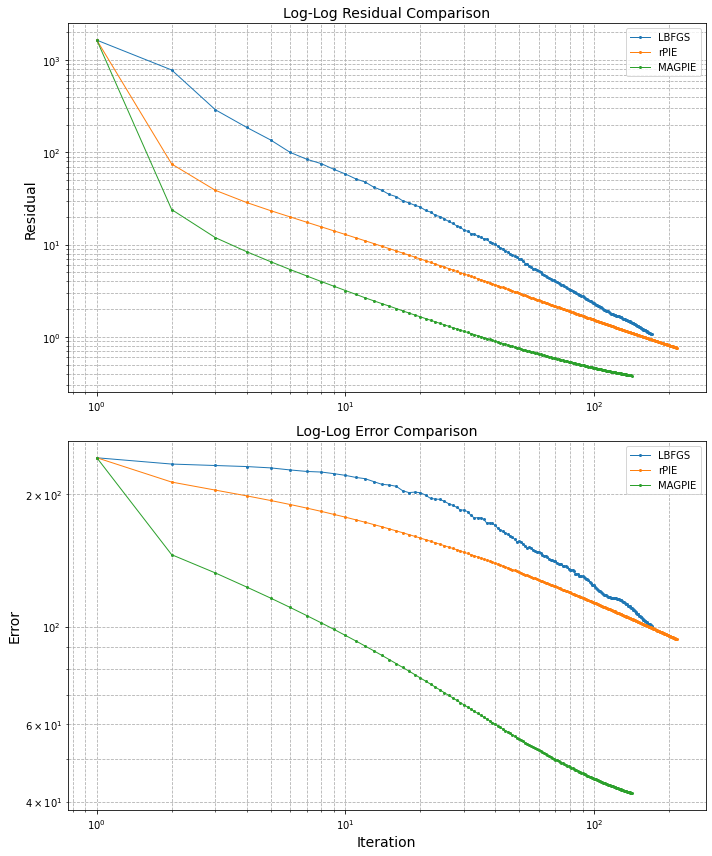

In [21]:
# Create a figure with 2 rows and 1 column of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# --- Plot on the top subplot (Residuals) ---
ax1.plot(np.arange(1, len(res_f_LBFGS)+1), res_f_LBFGS, label='LBFGS', linestyle='-', marker='o', linewidth=1, markersize=2)
ax1.plot(np.arange(1, len(res_rPIE)+1), res_rPIE, label='rPIE', linestyle='-', marker='o', linewidth=1, markersize=2)
ax1.plot(np.arange(1, len(res_MAGPIE)+1), res_MAGPIE, label='MAGPIE', linestyle='-', marker='o', linewidth=1, markersize=2)
#ax1.set_xlabel('Iteration', fontsize=18)
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_title('Log-Log Residual Comparison', fontsize=14)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, which="both", ls="--")

# --- Plot on the bottom subplot (Errors) ---
ax2.plot(np.arange(1, len(errors_LBFGS)+1), errors_LBFGS, label='LBFGS', linestyle='-', marker='o', linewidth=1, markersize=2)
ax2.plot(np.arange(1, len(errors_rPIE)+1), errors_rPIE, label='rPIE', linestyle='-', marker='o', linewidth=1, markersize=2)
ax2.plot(np.arange(1, len(errors_MAGPIE)+1), errors_MAGPIE, label='MAGPIE', linestyle='-', marker='o', linewidth=1, markersize=2)
ax2.set_xlabel('Iteration', fontsize=14)
ax2.set_ylabel('Error', fontsize=14)
ax2.set_title('Log-Log Error Comparison', fontsize=14)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, which="both", ls="--")
#plt.savefig('metric.png', dpi=200, bbox_inches='tight')

plt.tight_layout()
plt.show()



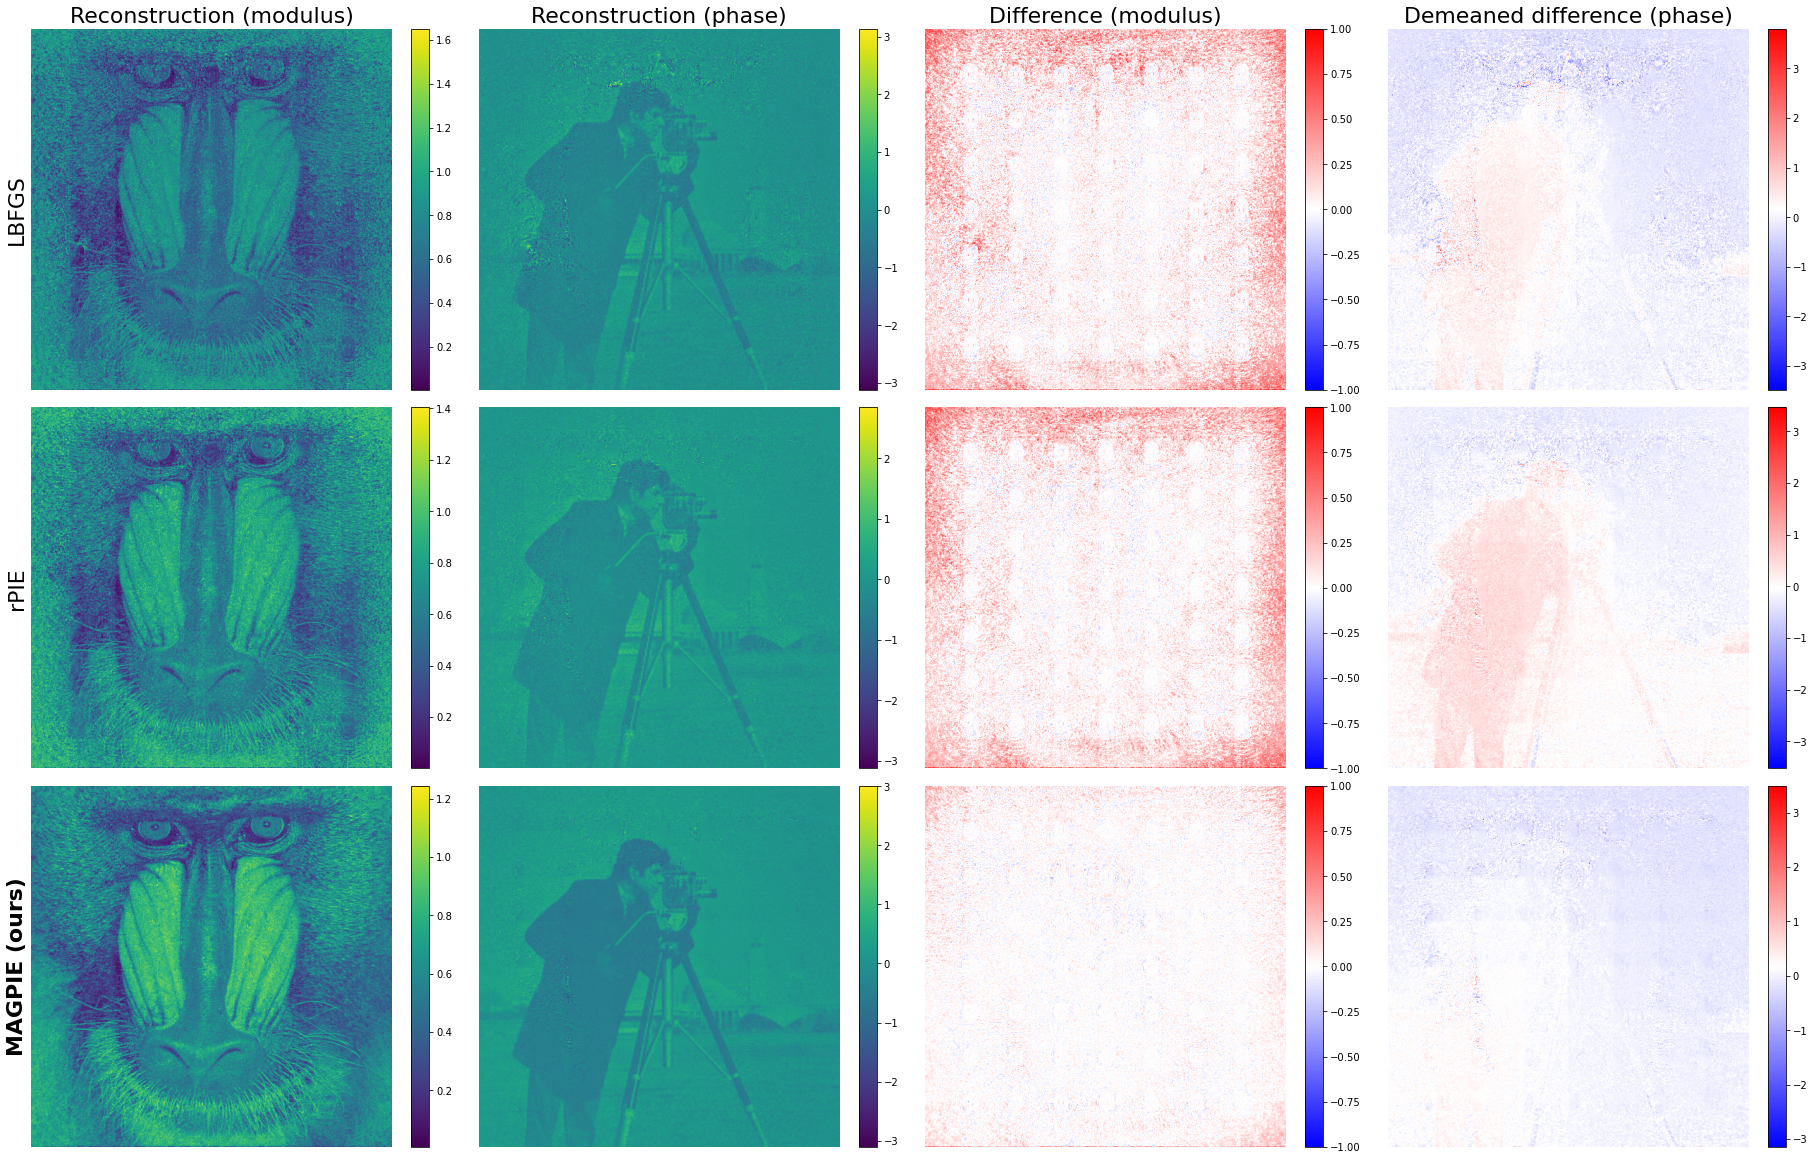

In [22]:
size = object_shape
rPIE_image = z_recon_rPIE
MAGPIE_image = z_recon_MAGPIE
LBFGS_image = zstar.view(np.complex128).reshape(object_shape)
ground_truth = ground_truth

intensity_ground_truth = np.abs(ground_truth)
phase_ground_truth = np.angle(ground_truth)

def calculate_difference(image, ground_truth):
    intensity_diff = np.abs(image) - intensity_ground_truth
    phase_diff = np.angle(image) - phase_ground_truth - np.mean(np.angle(image) - phase_ground_truth)
    return intensity_diff, phase_diff

intensity_LBFGS, phase_LBFGS = np.abs(LBFGS_image), np.angle(LBFGS_image)
intensity_rPIE, phase_rPIE = np.abs(rPIE_image), np.angle(rPIE_image)
intensity_MAGPIE, phase_MAGPIE = np.abs(MAGPIE_image), np.angle(MAGPIE_image)

# Calculate differences
intensity_diff_LBFGS, phase_diff_LBFGS = calculate_difference(LBFGS_image, ground_truth)
intensity_diff_rPIE, phase_diff_rPIE = calculate_difference(rPIE_image, ground_truth)
intensity_diff_MAGPIE, phase_diff_MAGPIE = calculate_difference(MAGPIE_image, ground_truth)

# Updated column titles and row labels
column_titles = [
    "Reconstruction (modulus)", 
    "Reconstruction (phase)", 
    "Difference (modulus)", 
    "Demeaned difference (phase)"
]
row_labels = ["LBFGS", "rPIE", "MAGPIE (ours)"]

# Prepare data for plotting: each tuple contains (intensity, phase, intensity_diff, phase_diff)
image_data = [
    (intensity_LBFGS, phase_LBFGS, intensity_diff_LBFGS, phase_diff_LBFGS),
    (intensity_rPIE, phase_rPIE, intensity_diff_rPIE, phase_diff_rPIE),
    (intensity_MAGPIE, phase_MAGPIE, intensity_diff_MAGPIE, phase_diff_MAGPIE),
]

# Create a new figure using subplots 
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 16), constrained_layout=True)

# Set column titles on the first row.
for j, title in enumerate(column_titles):
    axes[0, j].set_title(title, fontsize=22)

# Loop over each row of image data.
for i, (intensity, phase, intensity_diff, phase_diff) in enumerate(image_data):
    # Set the row label for the first column.
    if i == 2:
        axes[i, 0].set_ylabel(row_labels[i], fontsize=22, fontweight='bold')
    else:
        axes[i, 0].set_ylabel(row_labels[i], fontsize=22)

    # Remove spines and ticks for clarity.
    for j in range(4):
        ax = axes[i, j]
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

    # Plot the intensity image.
    im0 = axes[i, 0].imshow(intensity, cmap='viridis')
    fig.colorbar(im0, ax=axes[i, 0])

    # Plot the phase image.
    im1 = axes[i, 1].imshow(phase, cmap='viridis')
    fig.colorbar(im1, ax=axes[i, 1])
    
    # Plot the intensity difference image with symmetric scaling.
    max_intensity_diff = np.max(np.abs(intensity_diff))
    im2 = axes[i, 2].imshow(intensity_diff, cmap='bwr', vmin=-1, vmax=1)
    fig.colorbar(im2, ax=axes[i, 2])

    # Plot the phase difference image with symmetric scaling.
    max_phase_diff = np.max(np.abs(phase_diff))
    im3 = axes[i, 3].imshow(phase_diff, cmap='bwr')
    fig.colorbar(im3, ax=axes[i, 3])

#plt.savefig('reconstruction.png', dpi=60, bbox_inches='tight')
plt.show()